# NLP Going Deeper 14 : BERT pretrained model 제작

이번 노드에서는 일반적인 10M 정도의 작은 파라미터 사이즈의 BERT 모델을 만들어, 수백 MB 수준의 코퍼스 기반으로 pretrain 을 진행해 보도록 하겠습니다. 하지만 진행되는 과정은 정식 BERT와 동일할 테니 이를 토대로 pretrained model이 어떻게 만들어지는지를 경험할 것입니다.

모델을 만들고 학습시키는 것 이상으로 코퍼스 데이터를 가공해서 학습시켜야 할 task에 적합한 형태의 데이터셋으로 만들어가는 것이 큰 비중을 차지한다는 것을 알게 될 것입니다.

## 작업 환경 구성

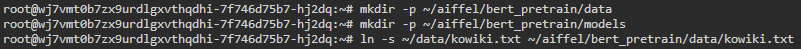

## Tokenizer 준비

BERT등의 pretrained model이 나오게 되었을 즈음, 자연어 처리 분야의 또 다른 중요한 흐름 중 하나는 BPE 등의 subword 기반의 토크나이징 기법이 주요한 방법론으로 굳어졌다는 점입니다. GPT의 BPE, BERT의 WordPiece 모델 등의 성공이 더욱 사람들에게 subword 기반의 토크나이저에 대한 확신을 주었습니다.

이번 노드에서는 SentencePiece 기반의 토크나이저를 준비하는 것으로 BERT pretrain 과정을 시작하게 됩니다.

In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


준비해 둔 한글 나무위키 코퍼스로부터 **8000의 vocab_size를 갖는 sentencepiece 모델을 생성**해 보겠습니다.

BERT에 사용되는 [MASK], [SEP], [CLS] 등의 주요 특수문자가 vocab에 포함되어야 함을 유의하는 것이 좋습니다.

In [2]:
import sentencepiece as spm
import os
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

print("8000 size의 모델 생성 절차 완료!")   # 완료메시지가 출력될 때까지 아무 출력내용이 없더라도 기다려 주세요.

8000 size의 모델 생성 절차 완료!


저는 심볼릭 링크를 걸어주는 방법을 사용하도록 하겠습니다.

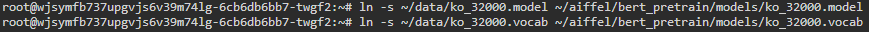

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

True

어떤 토큰이 만들어졌고, 토크나이징 결과가 어떻게 나오는지 확인합니다.

In [6]:
## 어떤 토큰이 만들어졌는지를 확인하는 코드입니다.
# 특수 token 7개를 제외한 나머지 tokens에 대하여
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))
print(vocab_list[:30])

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다', '었다', '▁지', '▁수', '▁19', '▁가', '▁시', '▁20', '▁기', '▁전', '▁아', '▁하', '▁있다', '▁다', '▁제', '했다', '하였', '▁일', '▁한', '▁중', '▁정']


In [7]:
## 토크나이징 결과가 어떻게 나오는지 확인하는 코드입니다.
## string 예시문은 트라이비의 'GOT YOUR BACK'이라는 노래 가사의 일부입니다!
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
string_a = "많이 어두운 밤이 끝날 것 같지 않던 시간 다들 쉽게 내뱉는 말 그냥 지나면 추억이야"
string_b = "아무 말 없이 난 그냥 네 뒤에 서 있을게 언제나 모든 순간순간에 네 편이 되어 줄 거야"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁많이', '▁어두운', '▁밤', '이', '▁끝날', '▁것', '▁같', '지', '▁않', '던', '▁시간', '▁다', '들', '▁쉽게', '▁내', '뱉', '는', '▁말', '▁그냥', '▁지나면', '▁추억', '이야', '[SEP]', '▁아무', '▁말', '▁없이', '▁난', '▁그냥', '▁네', '▁뒤에', '▁서', '▁있을', '게', '▁언제나', '▁모든', '▁순간', '순', '간에', '▁네', '▁편이', '▁되어', '▁줄', '▁거', '야', '[SEP]']


여기까지 SentencePiece 모델을 이용해 간단한 BERT의 Masked Language Model 학습용 데이터를 하나 생성하는 과정을 살펴보았습니다.

## 데이터 전처리 : MASK 생성

BERT의 Masked Language Model은 GPT의 Next Token Prediction 태스크처럼 '다음에 이어질 단어는?' 을 맞추는 게 아니라 '마스킹된 다음 빈칸에 알맞은 단어는?' 문제를 푸는 형식으로 구성됩니다. 이런 빈칸은 **전체 토큰의 15%** 정도가 적당하다고 합니다.

이전 스텝의 Masked LM 데이터셋 예시로 살펴보면 아래와 같습니다.

In [8]:
print(tokens_org)

# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt

['[CLS]', '▁많이', '▁어두운', '▁밤', '이', '▁끝날', '▁것', '▁같', '지', '▁않', '던', '▁시간', '▁다', '들', '▁쉽게', '▁내', '뱉', '는', '▁말', '▁그냥', '▁지나면', '▁추억', '이야', '[SEP]', '▁아무', '▁말', '▁없이', '▁난', '▁그냥', '▁네', '▁뒤에', '▁서', '▁있을', '게', '▁언제나', '▁모든', '▁순간', '순', '간에', '▁네', '▁편이', '▁되어', '▁줄', '▁거', '야', '[SEP]']


6

한편, Masked LM 태스크를 구성할 땐 띄어쓰기 단위로 한꺼번에 마스킹해 주는 것이 좋습니다. 다음과 같이 처리합니다.

In [9]:
# 띄어쓰기 단위로 mask 하기 위해서 index 분할
cand_idx = []  # word 단위의 index array
for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
        cand_idx[-1].append(i)
    else:
        cand_idx.append([i])

# 결과확인
for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

[1] ['▁많이']
[2] ['▁어두운']
[3, 4] ['▁밤', '이']
[5] ['▁끝날']
[6] ['▁것']
[7, 8] ['▁같', '지']
[9, 10] ['▁않', '던']
[11] ['▁시간']
[12, 13] ['▁다', '들']
[14] ['▁쉽게']
[15, 16, 17] ['▁내', '뱉', '는']
[18] ['▁말']
[19] ['▁그냥']
[20] ['▁지나면']
[21, 22] ['▁추억', '이야']
[24] ['▁아무']
[25] ['▁말']
[26] ['▁없이']
[27] ['▁난']
[28] ['▁그냥']
[29] ['▁네']
[30] ['▁뒤에']
[31] ['▁서']
[32, 33] ['▁있을', '게']
[34] ['▁언제나']
[35] ['▁모든']
[36, 37, 38] ['▁순간', '순', '간에']
[39] ['▁네']
[40] ['▁편이']
[41] ['▁되어']
[42] ['▁줄']
[43, 44] ['▁거', '야']


한편, 랜덤한 마스킹을 위해서 순서를 섞는 작업을 걸어줍니다.

In [10]:
random.shuffle(cand_idx)

In [11]:
cand_idx

[[12, 13],
 [21, 22],
 [6],
 [34],
 [9, 10],
 [25],
 [7, 8],
 [24],
 [39],
 [32, 33],
 [19],
 [20],
 [28],
 [14],
 [15, 16, 17],
 [29],
 [26],
 [36, 37, 38],
 [41],
 [11],
 [18],
 [42],
 [43, 44],
 [31],
 [30],
 [2],
 [27],
 [35],
 [3, 4],
 [1],
 [5],
 [40]]

개선된 Masking 로직을 다음과 같이 구현할 수 있습니다. 마스킹된 결과를 이전과 비교해 봅시다.

In [12]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

mask_lms = []  # mask 된 값
for index_set in cand_idx:
    if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
          break
    if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
          continue
    dice = random.random()  # 0..1 사이의 확률 값

    for index in index_set:
        masked_token = None
        if dice < 0.8:  # 80% replace with [MASK]
            masked_token = "[MASK]"
        elif dice < 0.9: # 10% keep original
            masked_token = tokens[index]
        else:  # 10% random word
            masked_token = random.choice(vocab_list)
        mask_lms.append({"index": index, "label": tokens[index]})
        tokens[index] = masked_token

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens)

tokens_org
['[CLS]', '▁많이', '▁어두운', '▁밤', '이', '▁끝날', '▁것', '▁같', '지', '▁않', '던', '▁시간', '▁다', '들', '▁쉽게', '▁내', '뱉', '는', '▁말', '▁그냥', '▁지나면', '▁추억', '이야', '[SEP]', '▁아무', '▁말', '▁없이', '▁난', '▁그냥', '▁네', '▁뒤에', '▁서', '▁있을', '게', '▁언제나', '▁모든', '▁순간', '순', '간에', '▁네', '▁편이', '▁되어', '▁줄', '▁거', '야', '[SEP]'] 

tokens
['[CLS]', '▁많이', '▁어두운', '▁밤', '이', '▁끝날', '[MASK]', '▁같', '지', '▁않', '던', '▁시간', '[MASK]', '[MASK]', '▁쉽게', '▁내', '뱉', '는', '▁말', '▁그냥', '▁지나면', '카와', '▁화재로', '[SEP]', '▁아무', '▁말', '▁없이', '▁난', '▁그냥', '▁네', '▁뒤에', '▁서', '▁있을', '게', '[MASK]', '▁모든', '▁순간', '순', '간에', '▁네', '▁편이', '▁되어', '▁줄', '▁거', '야', '[SEP]']


Masked LM의 라벨 데이터도 아래와 같이 생성한 후 정리해 두기로 합시다.

In [13]:
# 순서 정렬 및 mask_idx, mask_label 생성
mask_lms = sorted(mask_lms, key=lambda x: x["index"])
mask_idx = [p["index"] for p in mask_lms]
mask_label = [p["label"] for p in mask_lms]

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

mask_idx   : [6, 12, 13, 21, 22, 34]
mask_label : ['▁것', '▁다', '들', '▁추억', '이야', '▁언제나']


In [14]:
mask_lms

[{'index': 6, 'label': '▁것'},
 {'index': 12, 'label': '▁다'},
 {'index': 13, 'label': '들'},
 {'index': 21, 'label': '▁추억'},
 {'index': 22, 'label': '이야'},
 {'index': 34, 'label': '▁언제나'}]

### create_pretrain_mask() : Masked LM을 위한 코퍼스 생성 메소드

In [15]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label

create_pretrain_mask() 수행 결과를 다시 한 번 확인해 봅니다.

In [17]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

tokens_org
['[CLS]', '▁많이', '▁어두운', '▁밤', '이', '▁끝날', '▁것', '▁같', '지', '▁않', '던', '▁시간', '▁다', '들', '▁쉽게', '▁내', '뱉', '는', '▁말', '▁그냥', '▁지나면', '▁추억', '이야', '[SEP]', '▁아무', '▁말', '▁없이', '▁난', '▁그냥', '▁네', '▁뒤에', '▁서', '▁있을', '게', '▁언제나', '▁모든', '▁순간', '순', '간에', '▁네', '▁편이', '▁되어', '▁줄', '▁거', '야', '[SEP]'] 

tokens
['[CLS]', '▁많이', '[MASK]', '▁밤', '이', '[MASK]', '[MASK]', '▁같', '지', '▁않', '던', '▁시간', '▁다', '들', '▁쉽게', '▁내', '뱉', '는', '▁말', '▁그냥', '[MASK]', '▁추억', '이야', '[SEP]', '▁아무', '▁말', '▁없이', '▁난', '▁그냥', '▁네', '▁뒤에', '렸기', '▁있을', '게', '▁언제나', '[MASK]', '▁순간', '순', '간에', '▁네', '▁편이', '▁되어', '▁줄', '▁거', '야', '[SEP]'] 

mask_idx   : [2, 5, 6, 20, 31, 35]
mask_label : ['▁어두운', '▁끝날', '▁것', '▁지나면', '▁서', '▁모든']


## 데이터 전처리 : NSP Pair 생성

BERT의 pretrain task로 **Next Sentence Prediction(NSP)** 이 있습니다. 문장 2개를 붙여 놓고 두 문장이 이어지는 것인지 아닌지 문장 호응관계를 맞출 수 있게 하는 것입니다.

예시문은 아래 링크의 글의 일부분을 Copy 및 편집한 것임을 밝힙니다.

**링크 : https://www.brainmedia.co.kr/MediaContent/MediaContentView.aspx?MenuCd=BRAINTRAINING&contIdx=22088**

In [18]:
string = """퇴근 후 각자의 공간에서 참석하는 화상 모임의
주된 활동은 국학기공 수련이다. 몸과 마음의 고단함을
수련으로 비우고 회복하는 소중한 시간이다.
간단한 동작을 하면서 호흡과 어우러지는 몸의 움직임을
느끼며 몸과 마음을 지금 이곳에 머물도록 하는
시공간적 집중상태로 한결 편안한 분위기가 된다.
어느 정도 호흡이 정리되면 머리가 맑아지고 몸도 가벼워진
상태에서 몇몇 선생님들의 국학기공 교육 활동 사례를
공유하는 시간을 갖는다."""

In [19]:
# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

[['▁퇴', '근', '▁후', '▁각자의', '▁공간에서', '▁참석', '하는', '▁화', '상', '▁모임', '의'],
 ['▁주된',
  '▁활동은',
  '▁국',
  '학',
  '기',
  '공',
  '▁수련',
  '이다',
  '.',
  '▁몸',
  '과',
  '▁마음의',
  '▁고',
  '단',
  '함을'],
 ['▁수련', '으로', '▁비', '우고', '▁회복', '하는', '▁소', '중한', '▁시간', '이다', '.']]

우선 원문에서 이어진 두 문장씩 짝지어 보겠습니다.

In [20]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [21]:
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        #######################################
        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
          
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 6 69 [['▁퇴', '근', '▁후', '▁각자의', '▁공간에서', '▁참석', '하는', '▁화', '상', '▁모임', '의'], ['▁주된', '▁활동은', '▁국', '학', '기', '공', '▁수련', '이다', '.', '▁몸', '과', '▁마음의', '▁고', '단', '함을'], ['▁수련', '으로', '▁비', '우고', '▁회복', '하는', '▁소', '중한', '▁시간', '이다', '.'], ['▁간단한', '▁동작을', '▁하면서', '▁호흡', '과', '▁어우러', '지는', '▁몸의', '▁움직임을'], ['▁느끼', '며', '▁몸', '과', '▁마음을', '▁지금', '▁이곳에', '▁머물', '도록', '▁하는'], ['▁시', '공간', '적', '▁집중', '상태', '로', '▁한', '결', '▁편안', '한', '▁분위기가', '▁된다', '.']]
tokens_a: 46 ['▁퇴', '근', '▁후', '▁각자의', '▁공간에서', '▁참석', '하는', '▁화', '상', '▁모임', '의', '▁주된', '▁활동은', '▁국', '학', '기', '공', '▁수련', '이다', '.', '▁몸', '과', '▁마음의', '▁고', '단', '함을', '▁수련', '으로', '▁비', '우고', '▁회복', '하는', '▁소', '중한', '▁시간', '이다', '.', '▁간단한', '▁동작을', '▁하면서', '▁호흡', '과', '▁어우러', '지는', '▁몸의', '▁움직임을']
tokens_b: 23 ['▁느끼', '며', '▁몸', '과', '▁마음을', '▁지금', '▁이곳에', '▁머물', '도록', '▁하는', '▁시', '공간', '적', '▁집중', '상태', '로', '▁한', '결', '▁편안', '한', '▁분위기가', '▁된다', '.']

current_chunk: 3 30 [['▁어느', '▁정도', '▁호흡', '이', '▁정리', '되면',

짝지은 두 문장을 그대로 두면 NSP task의 true label 케이스가 되고, 둘의 순서를 뒤바꾸면 false label 케이스가 될 것입니다.

두 문장의 최대 길이를 유지하도록 trim을 적용한 후 50%의 확률로 T/F 케이스를 생성해 보겠습니다.

In [22]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [23]:
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        #######################################
        if random.random() < 0.5:  # 50% 확률로 swap
            is_next = 0
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1
        # max_seq 보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 6 69 [['▁퇴', '근', '▁후', '▁각자의', '▁공간에서', '▁참석', '하는', '▁화', '상', '▁모임', '의'], ['▁주된', '▁활동은', '▁국', '학', '기', '공', '▁수련', '이다', '.', '▁몸', '과', '▁마음의', '▁고', '단', '함을'], ['▁수련', '으로', '▁비', '우고', '▁회복', '하는', '▁소', '중한', '▁시간', '이다', '.'], ['▁간단한', '▁동작을', '▁하면서', '▁호흡', '과', '▁어우러', '지는', '▁몸의', '▁움직임을'], ['▁느끼', '며', '▁몸', '과', '▁마음을', '▁지금', '▁이곳에', '▁머물', '도록', '▁하는'], ['▁시', '공간', '적', '▁집중', '상태', '로', '▁한', '결', '▁편안', '한', '▁분위기가', '▁된다', '.']]
is_next: 0
tokens_a: 50 ['.', '▁몸', '과', '▁마음의', '▁고', '단', '함을', '▁수련', '으로', '▁비', '우고', '▁회복', '하는', '▁소', '중한', '▁시간', '이다', '.', '▁간단한', '▁동작을', '▁하면서', '▁호흡', '과', '▁어우러', '지는', '▁몸의', '▁움직임을', '▁느끼', '며', '▁몸', '과', '▁마음을', '▁지금', '▁이곳에', '▁머물', '도록', '▁하는', '▁시', '공간', '적', '▁집중', '상태', '로', '▁한', '결', '▁편안', '한', '▁분위기가', '▁된다', '.']
tokens_b: 11 ['▁퇴', '근', '▁후', '▁각자의', '▁공간에서', '▁참석', '하는', '▁화', '상', '▁모임', '의']

current_chunk: 3 30 [['▁어느', '▁정도', '▁호흡', '이', '▁정리', '되면', '▁머리가', '▁맑', '아', '지고', '▁몸', '도', '

이제 두 문장 사이에 segment 처리를 해 주도록 합니다. 첫 번째 문장의 segment는 모두 0으로, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주는 것으로 마무리가 됩니다.

이전 스텝의 create_pretrain_mask() 까지 함께 호출되어 Mask LM용 데이터셋과 NSP용 데이터셋이 결합된 하나의 데이터셋으로 완성될 것입니다.

**참고로, BERT의 pretrain은 두 가지 task가 동시에 수행 가능합니다! 😉😉**

In [24]:
instances = []
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        if random.random() < 0.5:  # 50% 확률로 swap
            is_next = 0
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1
        # max_seq 보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #################################################
        # tokens & aegment 생성
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
        segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        print("tokens:", len(tokens), tokens)
        print("segment:", len(segment), segment)
        # mask
        tokens, mask_idx, mask_table = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
        print("masked tokens:", len(tokens), tokens)
        print("masked index:", len(mask_idx), mask_idx)
        print("masked label:", len(mask_label), mask_label)
        
        instance = {
            "tokens": tokens,
            "segment": segment,
            "is_next": is_next,
            "mask_idx": mask_idx,
            "mask_label": mask_label
        }
        instances.append(instance)
        ################################################
        print()
        
        current_chunk = []
        current_length = 0

current_chunk: 6 69 [['▁퇴', '근', '▁후', '▁각자의', '▁공간에서', '▁참석', '하는', '▁화', '상', '▁모임', '의'], ['▁주된', '▁활동은', '▁국', '학', '기', '공', '▁수련', '이다', '.', '▁몸', '과', '▁마음의', '▁고', '단', '함을'], ['▁수련', '으로', '▁비', '우고', '▁회복', '하는', '▁소', '중한', '▁시간', '이다', '.'], ['▁간단한', '▁동작을', '▁하면서', '▁호흡', '과', '▁어우러', '지는', '▁몸의', '▁움직임을'], ['▁느끼', '며', '▁몸', '과', '▁마음을', '▁지금', '▁이곳에', '▁머물', '도록', '▁하는'], ['▁시', '공간', '적', '▁집중', '상태', '로', '▁한', '결', '▁편안', '한', '▁분위기가', '▁된다', '.']]
is_next: 1
tokens_a: 26 ['▁퇴', '근', '▁후', '▁각자의', '▁공간에서', '▁참석', '하는', '▁화', '상', '▁모임', '의', '▁주된', '▁활동은', '▁국', '학', '기', '공', '▁수련', '이다', '.', '▁몸', '과', '▁마음의', '▁고', '단', '함을']
tokens_b: 35 ['▁수련', '으로', '▁비', '우고', '▁회복', '하는', '▁소', '중한', '▁시간', '이다', '.', '▁간단한', '▁동작을', '▁하면서', '▁호흡', '과', '▁어우러', '지는', '▁몸의', '▁움직임을', '▁느끼', '며', '▁몸', '과', '▁마음을', '▁지금', '▁이곳에', '▁머물', '도록', '▁하는', '▁시', '공간', '적', '▁집중', '상태']
tokens: 64 ['[CLS]', '▁퇴', '근', '▁후', '▁각자의', '▁공간에서', '▁참석', '하는', '▁화', '상', '▁모임', '의', '▁주된', '

최종 완성된 데이터셋의 결과는 다음과 같이 나타납니다.

In [26]:
# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁퇴', '근', '▁후', '▁각자의', '▁공간에서', '[MASK]', '[MASK]', '▁화', '상', '▁모임', '의', '▁주된', '▁활동은', '▁국', '학', '기', '공', '▁수련', '이다', '.', '[MASK]', '[MASK]', '▁마음의', '▁고', '단', '함을', '[SEP]', '▁수련', '으로', '▁비', '우고', '▁회복', '하는', '▁대만', '澗', '▁시간', '이다', '.', '▁간단한', '▁동작을', '[MASK]', '▁호흡', '과', '▁어우러', '지는', '▁몸의', '▁움직임을', '▁느끼', '며', '▁몸', '과', '▁마음을', '▁지금', '▁이곳에', '▁머물', '도록', '▁하는', '▁시', '공간', '적', '▁집중', '상태', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 1, 'mask_idx': [1, 2, 6, 7, 21, 22, 34, 35, 41], 'mask_label': ['▁어두운', '▁끝날', '▁것', '▁지나면', '▁서', '▁모든']}
{'tokens': ['[CLS]', '▁어느', '▁정도', '▁호흡', '이', '▁정리', '되면', '▁머리가', '▁맑', '아', '지고', '▁몸', '도', '▁가벼', '워', '진', '▁상태에서', '[MASK]', '▁선생님', '들의', '▁국', '학', '기', '공', '▁교육', '▁활동', '▁사례를', '[SEP]', '[MASK]', '▁시간을', '▁갖는다', '.', 

### create_pretrain_instances() : Next Sentence Prediction을 위한 코퍼스 생성 메소드

In [27]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

create_pretrain_instances() 수행 결과를 다시 한번 확인해 봅니다.

In [29]:
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁시간', '이다', '.', '▁간단한', '▁동작을', '[MASK]', '▁호흡', '과', '▁어우러', '지는', '▁몸의', '▁움직임을', '▁느끼', '며', '▁몸', '과', '[MASK]', '▁지금', '▁이곳에', '▁머물', '도록', '▁하는', '▁시', '공간', '적', '▁집중', '상태', '로', '[MASK]', '[MASK]', '▁편안', '한', '▁분위기가', '[MASK]', '[MASK]', '[SEP]', '체의', '▁치안', '▁후', '[MASK]', '▁공간에서', '▁참석', '하는', '▁화', '상', '▁모임', '의', '▁주된', '▁활동은', '▁국', '학', '기', '공', '▁수련', '이다', '.', '▁몸', '과', '▁마음의', '▁고', '단', '함을', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [6, 17, 29, 30, 34, 35, 37, 38, 40], 'mask_label': ['▁하면서', '▁마음을', '▁한', '결', '▁된다', '.', '▁퇴', '근', '▁각자의']}
{'tokens': ['[CLS]', '[MASK]', '▁정도', '▁호흡', '이', '[MASK]', '[MASK]', '▁머리가', '▁맑', '아', '지고', '▁몸', '도', '▁가벼', '워', '진', '▁상태에서', '▁몇몇', '▁선생님', '들의', '▁국', '학', '기', '공', '▁교육', '▁활동', '▁사례를', '[SEP]',

## 데이터 전처리 : 데이터셋 완성

이제 우리가 다루어야 할 **kowiki.txt**에 대해 본격적으로 살펴보고자 합니다.

In [30]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

전체 라인 수가 거의 400만 개에 육박합니다. 어마어마하게 데이터가 많습니다.

한편, **위키 문서는 하나의 도큐먼트가 주제 키워드에 대해 상세 내용이 설명으로 따라붙어 있는 형태**로 구성되어 있습니다.

도큐먼트 주제별로 잘 나눠지는지도 확인해 보겠습니다.

In [31]:
# 위키가 주제별로 잘 나눠지는지 여부 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines :", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break
                doc = []
        else:  # doc에 저장
            pieces = vocab.encode_as_pieces(line)
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

21 lines : ['▁지미', '▁카터']
['▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(,', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁39', '번째', '▁대통령', '▁(19', '77', '년', '▁~', '▁1981', '년', ')', '이다', '.']
['▁그는', '▁2002', '년', '▁말', '▁인권', '과', '▁중재', '▁역할에', '▁대한', '▁공로를', '▁인정받아', '▁노벨', '▁평화', '상을', '▁받게', '▁되었다', '.']

14 lines : ['▁수학']
['▁수학', '(', '數', '學', ',', '▁)', '은', '▁양', ',', '▁구조', ',', '▁공간', ',', '▁변화', ',', '▁미', '적', '분', '▁등의', '▁개념을', '▁다루는', '▁학문이다', '.', '▁현대', '▁수학', '은', '▁형식', '▁논', '리를', '▁이용해서', '▁공', '리로', '▁구성된', '▁추상', '적', '▁구조를', '▁연구하는', '▁학문', '으로', '▁여겨', '지기도', '▁한다', '.', '▁수학', '은', '▁그', '▁구조와', '▁발전', '▁과정', '에서는', '▁자연', '과학', '에', '▁속하는', '▁물리', '학을', '▁비롯한', '▁다른', '▁학문', '들과', '▁깊은', '▁연', '관을', '▁맺고', '▁있다', '.', '▁하지만', ',', '▁어느', '▁과학의', '▁분야', '들과는', '▁달리', ',', '▁자연', '계에서', '▁관측', '되지', '▁않는', '▁개념', '들에', '▁대해서', '까지', '▁이론을', '▁일반화', '▁및', '▁추상', '화', '시킬', '▁수', '▁있다는', '▁차이가', '▁있다고', '▁한다', '.', '▁수

이전 스텝에서 완성했던 **create_pretrain_instances()** 를 코퍼스에 적용할 수 있는지 몇 라인에 대해서만 확인해 봅시다.

In [32]:
# instance 생성 기능 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # save
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])
                print(instances[-1])
                print()
                doc = []
                if 0 < count:  # 테스트를 위해서 부분 처리 함
                    count -= 1
                else:
                    break
        else:  # doc에 저장
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

doc: 21 instances: 10
{'tokens': ['[CLS]', '▁X', '선', '▁결정', '학', '▁등이', '▁개발되어', '▁유기', '▁화합물', '▁분석', '에', '▁있어서', '[MASK]', '▁중요한', '▁방법으로', '▁자리잡았다', '.', '▁플라스틱', ',', '▁합성', '섬유', '등의', '▁고분', '자', '물질', '▁등도', '▁유기', '화', '학에서', '▁다루', '어진다', '.', '[SEP]', '[MASK]', '[MASK]', '[MASK]', '▁탄', '소로', '▁이루어진', '[MASK]', '[MASK]', '▁연구하는', '▁분', '과', '이다', '.', '▁원래', '▁유기', '▁화합', '물은', '▁식물', '이나', '▁동물', '로부터', '▁추출', '해', '낸', '▁화합', '물을', '▁뜻', '하였으나', '[MASK]', '▁유기', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 1, 'mask_idx': [12, 15, 16, 33, 34, 35, 39, 40, 61], 'mask_label': ['▁매우', '▁자리잡았다', '.', '▁유기', '화', '학은', '▁화합', '물을', '▁지금은']}
{'tokens': ['[CLS]', '▁X', '선', '▁결정', '학', '▁등이', '[MASK]', '▁유기', '▁화합물', '▁분석', '에', '[MASK]', '▁매우', '▁중요한', '▁방법으로', '▁자리잡았다', '.', '▁플라스틱', ',', '▁합성', '섬유',

### make_pretrain_data() : BERT pretrain 데이터셋 생성 메소드

전체 전처리 과정을 거쳐 최종적으로 만들어지는 BERT pretrain 데이터셋 생성 메소드는 다음과 같습니다.

In [33]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

이제 약 400만 라인에 해당하는 전체 코퍼스에 대해 **make_pretrain_data()** 를 구동시켜 봅니다. 약 10여분 가량 시간이 소요될 수 있습니다.

최종적으로 생성된 데이터셋은 json 포맷으로 저장될 것입니다.

In [34]:
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [35]:
# line 수 확인
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

862285

데이터셋 파일을 만드는 것까지 진행해 보았습니다.

하지만 여기서 고려해야 할 점이 있습니다. 우리가 다루어야 할 데이터셋은 사이즈가 큽니다. 만들어질 json 데이터파일의 크기가 1.4GB 정도 됩니다. 실제 BERT 학습용의 백 분의 일 사이즈 정도밖에 안 되겠지만 그럼에도 불구하고 이렇게 큰 파일을 로딩하는 함수를 만들 때는 메모리 사용량과 관련해 고려해야 할 점이 있습니다.

그래서 우리는 넘파이의 **np.memmap**을 사용해서 메모리 사용량을 최소화하는 방법을 시도해 볼 것입니다.

In [36]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# 만약 일반적인 Numpy Array에다 데이터를 로딩한다면 이렇게 되겠지만
# enc_tokens = np.zeros((total, n_seq), np.int32)
# dec_tokens = np.zeros((total, n_seq), np.int32)
# labels_nsp = np.zeros((total,), np.int32)
# labels_mlm = np.zeros((total, n_seq), np.int32)

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

만들어진 json 파일을 라인 단위로 읽어 들여 np.memmap에 로딩해 봅시다.

In [37]:
# 라인 단위로 처리
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=total)):
        if 5 < i:  # 테스트를 위해서 5개만 확인
            break
        data = json.loads(line)
        # encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))
        # segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))
        # nsp label
        label_nsp = data["is_next"]
        # mlm label
        mask_idx = np.array(data["mask_idx"], dtype=np.int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
        label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
        label_mlm[mask_idx] = mask_label

        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

  0%|          | 0/862285 [00:00<?, ?it/s]

{'tokens': ['[CLS]', '▁"', '땅', '콩', '▁농부', '"', '▁(', 'P', 'ean', 'ut', '▁F', 'ar', 'mer', ')', '로', '[MASK]', '[MASK]', '▁1962', '년', '▁조지아', '[MASK]', '[MASK]', '▁의원', '▁선거에서', '[MASK]', '[MASK]', '▁그', '▁선거가', '▁부정', '선거', '▁', '였', '음을', '▁입증', '하게', '▁되어', '▁당선', '되고', ',', '▁1966', '년', '[MASK]', '▁주', '▁지사', '▁선거에', '▁낙선', '하지만', '▁1970', '년', '▁조지아', '[MASK]', '▁지', '사를', '▁역임했다', '.', '▁대통령이', '▁되기', '▁전', '▁조지아', '주', '▁상원의', '원을', '▁두', '번', '▁연', '임', '했으며', ',', '▁1971', '년부터', '▁1975', '년까지', '▁조지아', '▁지', '사로', '▁근무했다', '.', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁미국에', '▁사는', '▁흑인', '▁등용', '법을', '▁내세', '웠다', '.', '[SEP]', '▁지미', '[MASK]', '▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카터', '▁주니어', '(,', '[MASK]', '[MASK]', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '[MASK]', '▁미국', '▁39', '번째', '▁대통령', '▁(19', '77', '년', '▁~', '▁1981', '년', ')', '이다', '.', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

###  load_pre_train_data() : 학습에 필요한 데이터를 로딩하는 함수

**np.memmap**을 사용해 메모리 효율적으로 만들어진 데이터를 로딩하는 함수를 아래와 같이 구성하였습니다.

In [38]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [39]:
# 128000 건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

data load early stop 128000 128000


In [40]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([    5,   103, 28313, 28290, 19041, 27718,    98, 27878, 15784,
          2543,   309,   337,  5771, 27616, 27603,     6,     6,  3715,
         27625,  5551,     6,     6,  2378,  5249,     6,     6,    13,
         20590,  2386,  2163, 27596, 27671,   969,  8047,   173,   607,
          2387,   317, 27604,  3926, 27625,     6,    37, 18995,  8198,
          9858,  1447,  1921, 27625,  5551,     6,    18,   451,  4267,
         27599,  4864,  6436,    25,  5551, 27646, 18205,   928,   157,
         27821,    61, 27773,   530, 27604,  3372,   523,  3409,   673,
          5551,    18,   982, 13264, 27599,     6,     6,     6,     6,
             6,     6,  6945,  3554,  6719, 12788,  2046,  5890,  1853,
         27599,     4, 16415,     6,  3324,  1042,   103, 27610, 27686,
         27718, 25250,  7504,   416,     6,     6,   131, 27662,     7,
         27629,   203,   241, 27602,  4867,     6,   243,  5898,   796,
           663,  1647,  4630, 27625,   203,  3008, 27625, 27616,

## BERT 모델 구현

이제 본격적으로 BERT model을 구현해 보겠습니다.

**BERT가 transformer encoder로 구현되어 있다는 것은 자명합니다.**

이미 여러 번 다뤄 본 transformer의 모델 구조와 거의 유사하지만, 3개의 embedding 레이어를 가진다는 점에 유의해야 합니다.

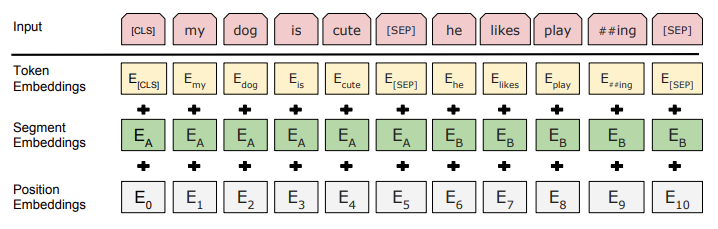

우선, 몇 가지 유틸리티 함수에 대한 정의를 내리겠습니다.

In [41]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask
print("함수가 성공적으로 구현되었다.")

함수가 성공적으로 구현되었다.


In [42]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))
print("함수가 성공적으로 구현되었다.")

함수가 성공적으로 구현되었다.


In [43]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer
print("함수가 성공적으로 구현되었다.")

함수가 성공적으로 구현되었다.


In [44]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
print("Config 클래스가 성공적으로 구현되었다.")

Config 클래스가 성공적으로 구현되었다.


이제 본격적으로 embedding 레이어를 쌓아 나가겠습니다. 아래는 Token Embedding의 구현입니다.

In [45]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs
    
print("SharedEmbedding 클래스가 정의되었다.")

SharedEmbedding 클래스가 정의되었다.


Positional Embedding 레이어는 다음과 같습니다.

In [46]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed
    
print("PositionalEmbedding 클래스가 정의되었다.")

PositionalEmbedding 클래스가 정의되었다.


상대적으로 매우 간단한 Segment Embedding은 별도의 레이어를 구현하지 않고 BERT 클래스에서 간단히 포함하는 정도로만 하겠습니다.

아래는 자주 보았던 **ScaleDotProductAttention**과 이를 활용한 **MultiHeadAttention**입니다.

In [47]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out
    
print("ScaleDotProductAttention 클래스가 정의되었다.")

ScaleDotProductAttention 클래스가 정의되었다.


In [48]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out
    
print("MultiHeadAttention 클래스도 정의되었다.")

MultiHeadAttention 클래스도 정의되었다.


이를 바탕으로 transformer encoder 레이어를 구성하면 다음과 같습니다.

In [49]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val
    
print("PositionWiseFeedForward 클래스가 정의되었다.")

PositionWiseFeedForward 클래스가 정의되었다.


In [50]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
    
print("Encoder Layer 클래스가 정의되었다.")

Encoder Layer 클래스가 정의되었다.


최종적으로 구성할 BERT 레이어는 아래와 같습니다.

In [51]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed
    
print("여기까지 따라오느라 고생했어요~👍")

여기까지 따라오느라 고생했어요~👍


BERT 레이어를 바탕으로 최종적으로 만들어질 pretrain용 BERT 모델 구성은 아래와 같습니다.

In [52]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [53]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 확인해 보겠습니다.

In [54]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 32007,
 'i_pad': 0}

In [55]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 5s 32ms/step - loss: 11.1932 - nsp_loss: 0.7411 - mlm_loss: 10.4521 - nsp_acc: 0.6000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 31ms/step - loss: 10.0369 - nsp_loss: 0.6172 - mlm_loss: 9.4197 - nsp_acc: 0.8000 - mlm_acc: 0.0133


**test_model.fit()** 이 잘 구동되었음을 확인할 수 있었습니다.

## Pretrain 진행

**loss나 accuracy와 같이 기본적으로 필요한 계산 관련 함수**를 미리 정의해 두도록 하겠습니다.

In [56]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

In [57]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

한편, Learning Rate 스케줄링도 아래와 같이 구현합니다. WarmUp 이후 consine 형태로 감소하는 스케줄을 적용합니다.

In [58]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

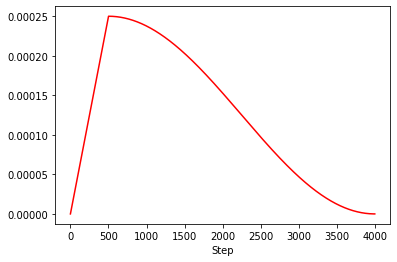

In [59]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

이제 모델을 실제로 빌드해 봅니다.

In [60]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 10629632    enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                 

**🔥🔥🔥 이제 본격적으로 학습을 진행합니다. 🔥🔥🔥**

1Epoch만 학습하는 데도 10분 이상의 상당한 시간이 소요될 것입니다. 그리고 메모리 오류가 날 수 있으니 배치 사이즈에도 유의해 주세요. 참고로 우리는 전체 데이터셋 중의 1/7 수준인 128000건만 로딩해서 사용 중이라는 것을 기억합시다.

Optimize 함수로는 Adam을 사용합니다.

In [61]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


In [62]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
2000/2000 [==============================] - 1134s 565ms/step - loss: 24.1836 - nsp_loss: 0.6661 - mlm_loss: 23.5175 - nsp_acc: 0.5711 - mlm_lm_acc: 0.0877

Epoch 00001: mlm_lm_acc improved from -inf to 0.08809, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 2/10
2000/2000 [==============================] - 1136s 568ms/step - loss: 20.5749 - nsp_loss: 0.6193 - mlm_loss: 19.9557 - nsp_acc: 0.6336 - mlm_lm_acc: 0.1184

Epoch 00002: mlm_lm_acc improved from 0.08809 to 0.12309, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 3/10
2000/2000 [==============================] - 1137s 569ms/step - loss: 19.2915 - nsp_loss: 0.5869 - mlm_loss: 18.7046 - nsp_acc: 0.6908 - mlm_lm_acc: 0.1366

Epoch 00003: mlm_lm_acc improved from 0.12309 to 0.13884, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 4/10
2000/2000 [==============================] - 1138s 569ms/step - loss: 18.0205 - nsp_loss: 0.5573 -

학습이 완료된 후, 시각화한 결과는 다음과 같았습니다.

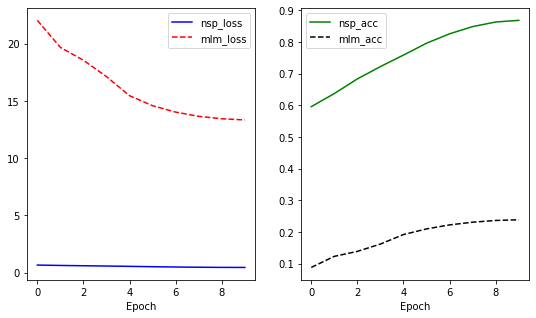

In [63]:
# 학습 흐름 시각화
plt.figure(figsize=(9, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 결과 정리

**이번 프로젝트 결과를 다음과 같이 정리할 수 있습니다.**

- pretrained된 모델로 10번의 Epoch를 진행하는 동안 loss는 안정적으로 감소한 반면 accuracy는 안정적으로 증가했습니다.
- nsp_loss, nsp_acc는 Next Sentence Prediction을 수행하여 나타난 손실과 예측 정확도를 나타냅니다.
- mlm_loss, mlm_acc는 Mask LM 부분에서 나타난 손실과 예측 정확도를 의미합니다.
- 대략 5 epoch 정도에서 정확도가 80%를 넘겼으며 10회째에서는 거의 87% 정도를 기록했습니다.

## 회고

- 단어장의 크기(vocab_size)를 실습에서의 32000의 25% 수준인 8000으로 설정하여 진행했음에도 불구하고 전체 모델 학습에 소요된 시간이 1 epoch 당 약 10분으로 대략 2시간 가까이 소요되었습니다.
- 단어장의 크기를 32000으로 돌리는 작업은 시간관계상 직접 하지 않고 넘어간 뒤 바로 8000개로 제한된 조건 하에서 프로젝트를 진행하여, 둘을 비교해 보지 못한 것은 아쉬웠습니다.